In [33]:
import numpy as np
import pandas as pd

# modeling utilities
import pydotplus 
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


# plotting libraries
import seaborn as sn
import matplotlib.pyplot as plt
import seaborn as sn

%matplotlib inline

sn.set_style('whitegrid')
sn.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [3]:
df = pd.read_csv('hour.csv')
print("Shape of dataset::{}".format(df.shape))

Shape of dataset::(17379, 17)


In [4]:
df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

In [5]:
# date time conversion
df['datetime'] = pd.to_datetime(df.datetime)

# categorical variables
df['season'] = df.season.astype('category')
df['is_holiday'] = df.is_holiday.astype('category')
df['weekday'] = df.weekday.astype('category')
df['weather_condition'] = df.weather_condition.astype('category')
df['is_workingday'] = df.is_workingday.astype('category')
df['month'] = df.month.astype('category')
df['year'] = df.year.astype('category')
df['hour'] = df.hour.astype('category')

In [6]:


def fit_transform_ohe(df,col_name):
    """This function performs one hot encoding for the specified
        column.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        col_name: the column to be one hot encoded

    Returns:
        tuple: label_encoder, one_hot_encoder, transformed column as pandas Series

    """
    # label encode the column
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    
    # one hot encoding
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return le,ohe,features_df

# given label encoder and one hot encoder objects, 
# encode attribute to ohe
def transform_ohe(df,le,ohe,col_name):
    """This function performs one hot encoding for the specified
        column using the specified encoder objects.

    Args:
        df(pandas.DataFrame): the data frame containing the mentioned column name
        le(Label Encoder): the label encoder object used to fit label encoding
        ohe(One Hot Encoder): the onen hot encoder object used to fit one hot encoding
        col_name: the column to be one hot encoded

    Returns:
        tuple: transformed column as pandas Series

    """
    # label encode
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels
    
    # ohe 
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    
    return features_df



In [8]:
X, X_test, y, y_test = train_test_split(df.iloc[:,0:-3], df.iloc[:,-1], 
                                                    test_size=0.33, random_state=42)

X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

print("Training set::{}{}".format(X.shape,y.shape))
print("Testing set::{}".format(X_test.shape))

Training set::(11643, 15)(11643, 2)
Testing set::(5736, 15)


In [9]:
cat_attr_list = ['season','is_holiday',
                 'weather_condition','is_workingday',
                 'hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

In [10]:
encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],
                              'ohe_enc':return_obj[1],
                              'feature_df':return_obj[2],
                              'col_name':col})

In [11]:
feature_df_list = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
                        for enc in encoded_attr_list \
                        if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Shape::{}".format(train_df_new.shape))

Shape::(11643, 19)


In [12]:
X = train_df_new
y= y.total_count.values.reshape(-1,1)

In [13]:
dtr = DecisionTreeRegressor(max_depth=4,
                            min_samples_split=5,
                            max_leaf_nodes=10)
dtr.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [14]:
dtr.score(X,y)

0.6056576562103779

In [16]:
dot_data = tree.export_graphviz(dtr, out_file=None) 
graph = pydotplus.graph_from_dot_data(dot_data) 
graph.write_pdf("bikeshare.pdf")

True

In [23]:
param_grid = {"criterion": ["mse", "mae"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20],
              "max_leaf_nodes": [5, 20],
              }

In [24]:
grid_cv_dtr = GridSearchCV(dtr, param_grid, cv=5)

In [25]:
grid_cv_dtr.fit(X,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=10, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'criterion': ['mse', 'mae'], 'min_samples_split': [10, 20, 40], 'max_depth': [2, 6, 8], 'min_samples_leaf': [20], 'max_leaf_nodes': [5, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [26]:
print("R-Squared::{}".format(grid_cv_dtr.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtr.best_params_))

R-Squared::0.7230000951278897
Best Hyperparameters::
{'criterion': 'mse', 'max_depth': 8, 'max_leaf_nodes': 20, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [27]:
df = pd.DataFrame(data=grid_cv_dtr.cv_results_)
df.head()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.015035,0.002530,0.002243,0.000385,mse,2,5,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484010,0.007223,28,0.491806,0.483696,0.489150,0.491167,0.487932,0.488750,0.002883
1,0.013276,0.001063,0.001946,0.000035,mse,2,5,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484010,0.007223,28,0.491806,0.483696,0.489150,0.491167,0.487932,0.488750,0.002883
2,0.014070,0.001107,0.002125,0.000191,mse,2,5,20,40,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.484010,0.007223,28,0.491806,0.483696,0.489150,0.491167,0.487932,0.488750,0.002883
3,0.013277,0.000344,0.001876,0.000051,mse,2,20,20,10,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.489907,0.007814,19,0.497879,0.489265,0.495486,0.497041,0.493573,0.494649,0.003066
4,0.013475,0.000556,0.002391,0.000559,mse,2,20,20,20,"{'criterion': 'mse', 'max_depth': 2, 'max_leaf...",...,0.489907,0.007814,19,0.497879,0.489265,0.495486,0.497041,0.493573,0.494649,0.003066


[Text(0.5,1,'Effect of Depth and Leaf Nodes on Model Performance')]

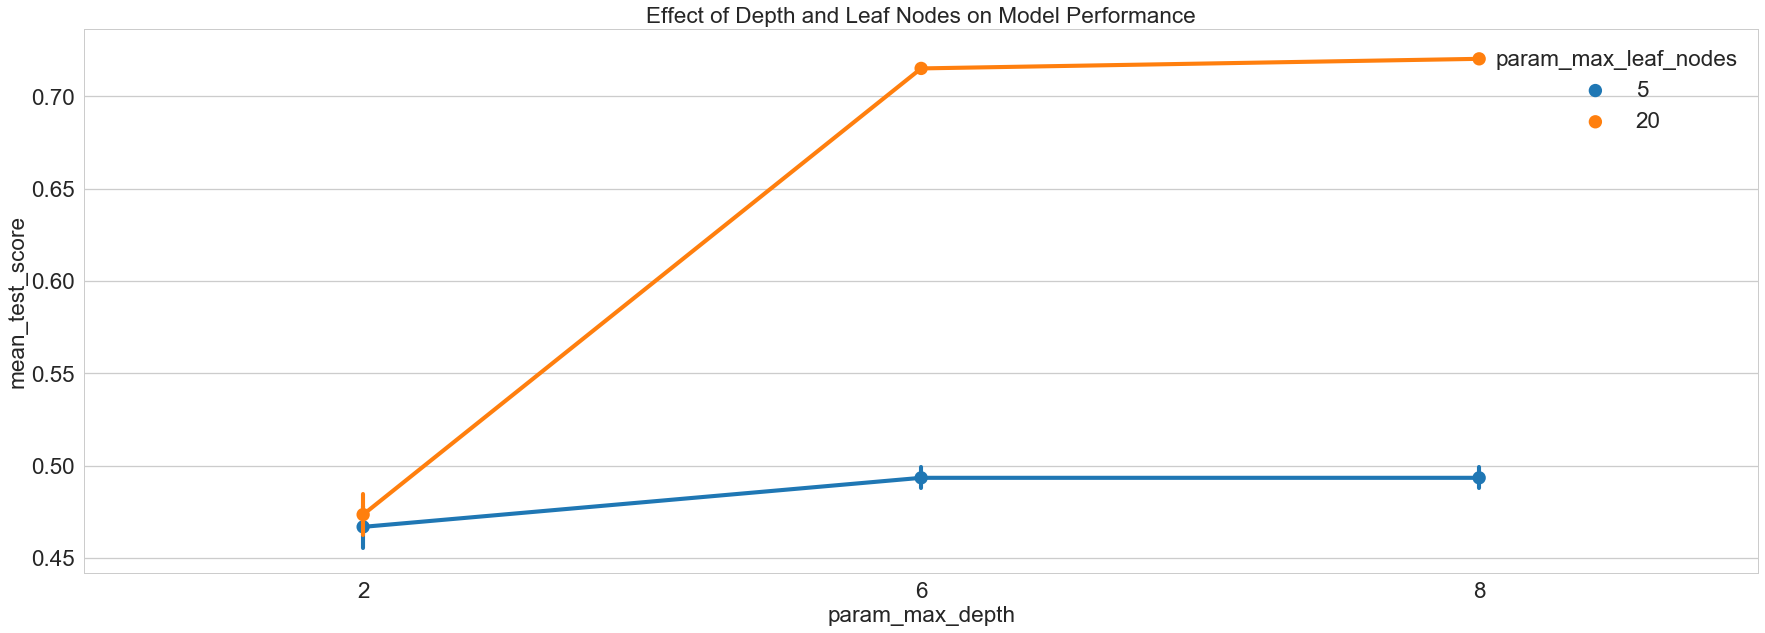

In [34]:
fig,ax = plt.subplots()
sn.pointplot(data=df[['mean_test_score',
                           'param_max_leaf_nodes',
                           'param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

In [29]:
predicted = grid_cv_dtr.best_estimator_.predict(X)
residuals = y.flatten()-predicted

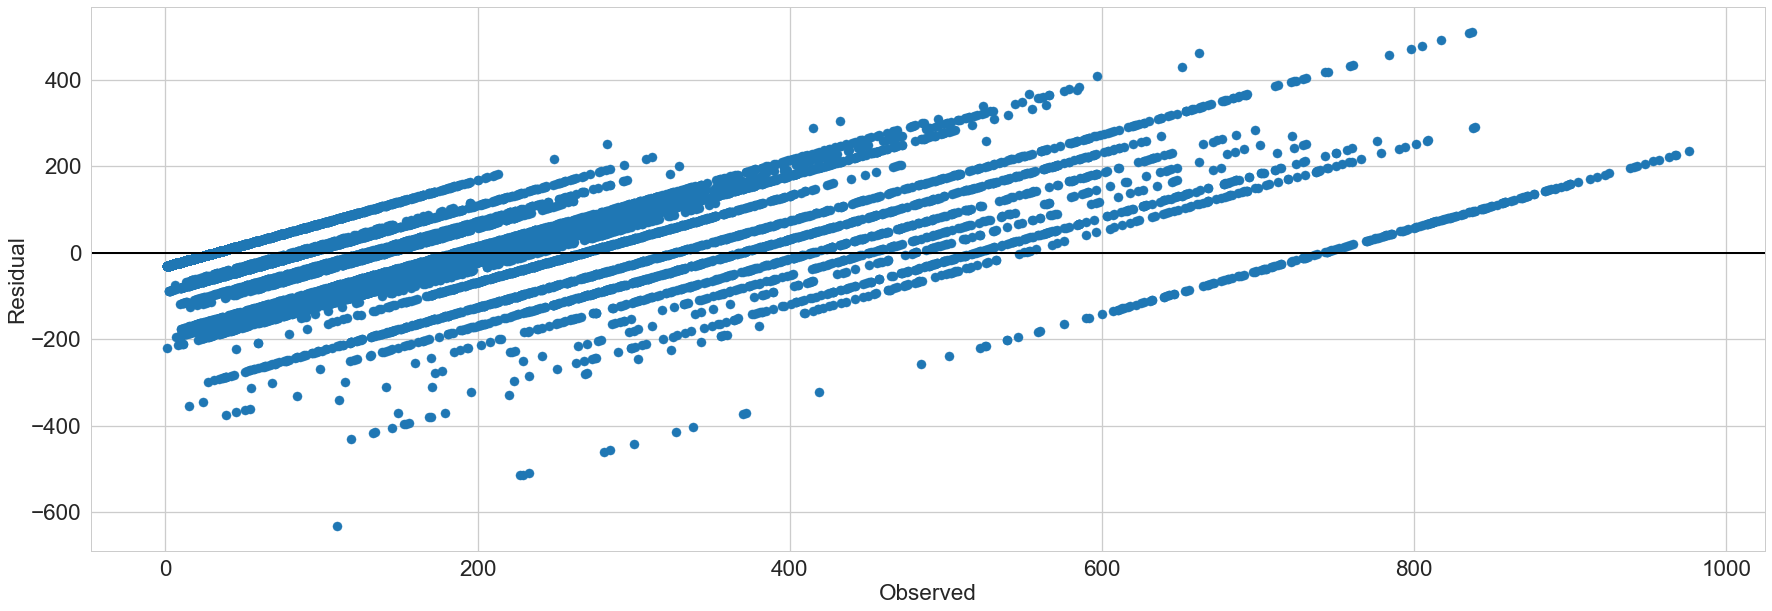

In [35]:
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [31]:
r2_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtr.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')

In [32]:
print("avg R-squared::{}".format(np.mean(r2_scores)))
print("MSE::{}".format(np.mean(mse_scores)))

avg R-squared::0.7270879502945142
MSE::-9101.821612092805


In [36]:
best_dtr_model = grid_cv_dtr.best_estimator_

In [37]:
test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),
                                   'col_name':col_name})
    
    
test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] for enc in test_encoded_attr_list if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1) 
print("Shape::{}".format(test_df_new.shape))

Shape::(5736, 19)


In [38]:
X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)

In [39]:
y_pred = best_dtr_model.predict(X_test)
residuals = y_test.flatten() - y_pred

In [40]:
r2_score = best_dtr_model.score(X_test,y_test)
print("R-squared::{}".format(r2_score))
print("MSE: %.2f"
      % metrics.mean_squared_error(y_test, y_pred))

R-squared::0.7308752113492447
MSE: 8585.47


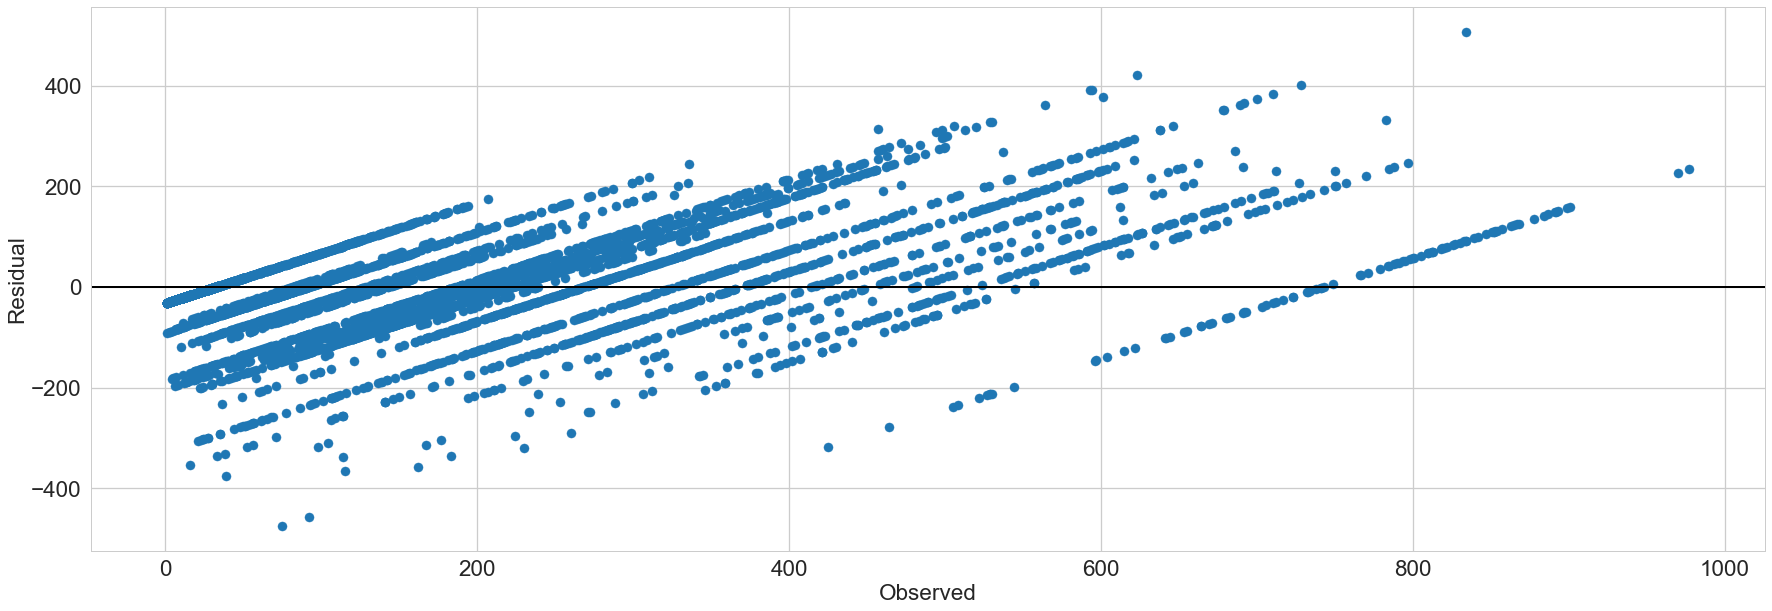

In [41]:
fig, ax = plt.subplots()
ax.scatter(y_test.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

r2_score = grid_cv_dtr.best_estimator_.score(X_test,y_test)